# Text classification with an RNN and CNN

This text classification tutorial trains a recurrent and a colvolutional neural networks on the IMDB large movie review dataset for sentiment analysis.


## RNN model
Recurrent neural networks, or RNNs (Rumelhart et al., 1986a), are a familyof neural networks for processing sequential data. Much as a convolutional networkis a neural network that is specialized for processing a grid of valuesXsuch asan image, a recurrent neural network is a neural network that is specialized forprocessing a sequence of values x(1), . . . , x(τ). Just as convolutional networkscan readily scale to images with large width and height, and some convolutionalnetworks can process images of variable size, recurrent networks can scale to muchlonger sequences than would be practical for networks without sequence-basedspecialization. Most recurrent networks can also process sequences of variablelength


<img src="https://www.tensorflow.org/text/tutorials/images/bidirectional.png" alt="Diagram of one-hot encodings" width="400" />

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
#Import matplotlib and create a helper function to plot graphs:

import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Setup input pipeline
The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS. See the loading text tutorial for details on how to load this sort of data manually.

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to C:\Users\asa279\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I wanted to see this movie ever since it was first advertised on TV. I went to Tinsel Town to see it Last Night at 7:40. I regret the day that wasted my ticket on this trash when I could of saw something better. The beginning was all a bunch sex trash and cliches. They exaggerated the way love works in reality. All of the girls were stereo types. The boyfriend was too stupid for his own age. The passing gases that the pregnant girl kept having barely got any laughs. The bank robbery was completely boring with gags that have been used in other movies. Their getaway car was an old beat up Chevy van that they claimed that had no breaks. Hey why didn't they get nice girlish vehicle for the robbery instead? It might have boosted the audience opinion about the movie. This movie was very low low low low low budgeted since nothing in there was damaged or destroyed. This movie had a lot of stuff in it that would drive Christian people nuts. Hey I even expected a car chase scene becau

### Create the text encoder
The raw text loaded by tfds needs to be processed before it can be used in a model. The simplest way to process text for training is using the experimental.preprocessing.TextVectorization layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 453,   6, ...,   0,   0,   0],
       [  2, 429,  17, ...,   0,   0,   0],
       [  1,   2, 115, ...,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".

2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [12]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I wanted to see this movie ever since it was first advertised on TV. I went to Tinsel Town to see it Last Night at 7:40. I regret the day that wasted my ticket on this trash when I could of saw something better. The beginning was all a bunch sex trash and cliches. They exaggerated the way love works in reality. All of the girls were stereo types. The boyfriend was too stupid for his own age. The passing gases that the pregnant girl kept having barely got any laughs. The bank robbery was completely boring with gags that have been used in other movies. Their getaway car was an old beat up Chevy van that they claimed that had no breaks. Hey why didn't they get nice girlish vehicle for the robbery instead? It might have boosted the audience opinion about the movie. This movie was very low low low low low budgeted since nothing in there was damaged or destroyed. This movie had a lot of stuff in it that would drive Christian people nuts. Hey I even expected a car chase scene bec

1. This model can be build as a tf.keras.Sequential.

2. The first layer is the encoder, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

4. This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

5. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

6. The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

7. The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.

8. The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

9. After the RNN has converted the sequence to a single vector the two layers.Dense do some final processing, and convert from this vector representation to a single logit as the classification output.

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.01623528]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.01623527]


Compile the Keras model to configure the training process:

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [21]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 440s 1s/step - loss: 0.6307 - accuracy: 0.5869 - val_loss: 0.4833 - val_accuracy: 0.7693
Epoch 2/2
391/391 [==============================] - 479s 1s/step - loss: 0.3955 - accuracy: 0.8214 - val_loss: 0.3585 - val_accuracy: 0.8469


In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 59s 152ms/step - loss: 0.3516 - accuracy: 0.8500
Test Loss: 0.3516426682472229
Test Accuracy: 0.8500000238418579


(0.0, 0.6443523734807968)

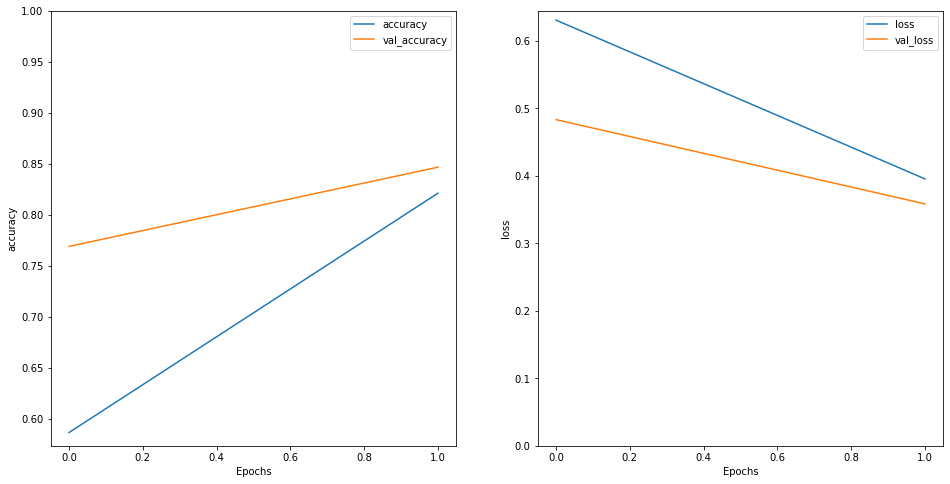

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [24]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

### Stack two or more LSTM layers
Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

- If False it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

- If True the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape (batch_size, timesteps, output_features)).

Here is what the flow of information looks like with return_sequences=True:

<img src="https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png" alt="Diagram of one-hot encodings" width="400" />

The interesting thing about using an RNN with return_sequences=True is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 652s 2s/step - loss: 0.6225 - accuracy: 0.5890 - val_loss: 0.4299 - val_accuracy: 0.8016
Epoch 2/2
391/391 [==============================] - 687s 2s/step - loss: 0.3890 - accuracy: 0.8314 - val_loss: 0.3562 - val_accuracy: 0.8443


In [28]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 186s 475ms/step - loss: 0.3478 - accuracy: 0.8518
Test Loss: 0.3478490710258484
Test Accuracy: 0.8517600297927856


In [29]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-0.8163839]]


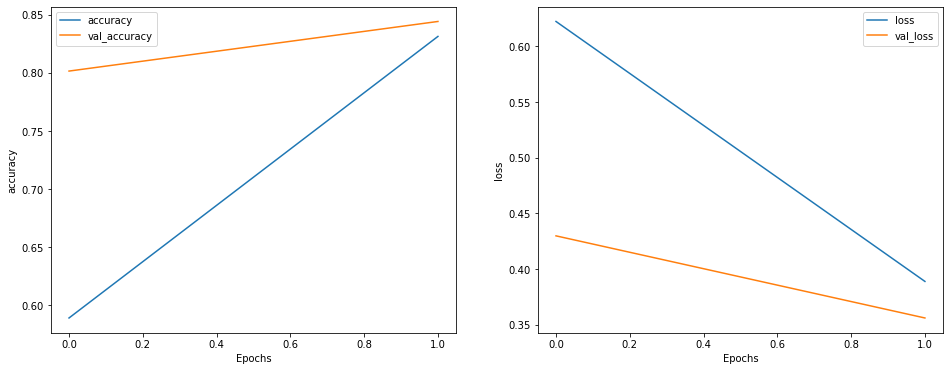

In [30]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

If you're interestied in building custom RNNs, see the Keras RNN Guide: https://www.tensorflow.org/guide/keras/rnn



## CNN for texts


<img src="https://miro.medium.com/max/11308/1*51dkqMhE21qKtzkEwl5PqA.jpeg" alt="Diagram of one-hot encodings" width="800" />


In this tutorial we will do the following steps:

- Data Preparation
- Train Embedding Layer
- Train word2vec Embedding
- Use Pre-trained Embedding


In [31]:
%pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [33]:
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)

# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('txt_sentoken/neg', vocab, True)
process_docs('txt_sentoken/pos', vocab, True)
# print the size of the vocab
print(len(vocab))
# print the top words in the vocab
print(vocab.most_common(50))

44276
[('film', 7983), ('one', 4946), ('movie', 4826), ('like', 3201), ('even', 2262), ('good', 2080), ('time', 2041), ('story', 1907), ('films', 1873), ('would', 1844), ('much', 1824), ('also', 1757), ('characters', 1735), ('get', 1724), ('character', 1703), ('two', 1643), ('first', 1588), ('see', 1557), ('way', 1515), ('well', 1511), ('make', 1418), ('really', 1407), ('little', 1351), ('life', 1334), ('plot', 1288), ('people', 1269), ('bad', 1248), ('could', 1248), ('scene', 1241), ('movies', 1238), ('never', 1201), ('best', 1179), ('new', 1140), ('scenes', 1135), ('man', 1131), ('many', 1130), ('doesnt', 1118), ('know', 1092), ('dont', 1086), ('hes', 1024), ('great', 1014), ('another', 992), ('action', 985), ('love', 977), ('us', 967), ('go', 952), ('director', 948), ('end', 946), ('something', 945), ('still', 936)]


In [34]:
# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))

25767


In [35]:
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

### Let's now train embedding layer!

In [36]:
from string import punctuation
from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load all training reviews
positive_docs = process_docs('txt_sentoken/pos', vocab, True)
negative_docs = process_docs('txt_sentoken/neg', vocab, True)
train_docs = negative_docs + positive_docs

# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)

# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])

# load all test reviews
positive_docs = process_docs('txt_sentoken/pos', vocab, False)
negative_docs = process_docs('txt_sentoken/neg', vocab, False)
test_docs = negative_docs + positive_docs
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# define model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d (Conv1D)              (None, 1310, 32)          25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 655, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20960)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                209610    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 2,812,053
Trainable params: 2,812,053
Non-trainable params: 0
______________________________________________

### Train word2vec Embedding

In [ ]:
%pip install gensim

In [37]:
from string import punctuation
from os import listdir
from gensim.models import Word2Vec

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def doc_to_clean_lines(doc, vocab):
    clean_lines = list()
    lines = doc.splitlines()
    for line in lines:
        # split into tokens by white space
        tokens = line.split()
        # remove punctuation from each token
        table = str.maketrans('', '', punctuation)
        tokens = [w.translate(table) for w in tokens]
        # filter out tokens not in vocab
        tokens = [w for w in tokens if w in vocab]
        clean_lines.append(tokens)
    return clean_lines

# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        doc = load_doc(path)
        doc_lines = doc_to_clean_lines(doc, vocab)
        # add lines to list
        lines += doc_lines
    return lines

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

# load training data
positive_docs = process_docs('txt_sentoken/pos', vocab, True)
negative_docs = process_docs('txt_sentoken/neg', vocab, True)
sentences = negative_docs + positive_docs
print('Total training sentences: %d' % len(sentences))

# train word2vec model
model = Word2Vec(sentences, vector_size=100, window=5, workers=8, min_count=1)
# summarize vocabulary size in model
words = list(model.wv.index_to_key)
print('Vocabulary size: %d' % len(words))

# save model in ASCII (word2vec) format
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

C:\Users\asa279\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Total training sentences: 58109
Vocabulary size: 25767


### Use Pre-trained Embedding

In this section, we will use a pre-trained word embedding prepared on a very large text corpus.

We can use the pre-trained word embedding developed in the previous section and the CNN model developed in the section before that.

In [39]:
from string import punctuation
from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc, vocab):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # filter out tokens not in vocab
    tokens = [w for w in tokens if w in vocab]
    tokens = ' '.join(tokens)
    return tokens

# load all docs in a directory
def process_docs(directory, vocab, is_trian):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_trian and filename.startswith('cv9'):
            continue
        if not is_trian and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load the doc
        doc = load_doc(path)
        # clean doc
        tokens = clean_doc(doc, vocab)
        # add to list
        documents.append(tokens)
    return documents

# load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix
 
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
 
# load all training reviews
positive_docs = process_docs('txt_sentoken/pos', vocab, True)
negative_docs = process_docs('txt_sentoken/neg', vocab, True)
train_docs = negative_docs + positive_docs
 
# create the tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(train_docs)
 
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(train_docs)
# pad sequences
max_length = max([len(s.split()) for s in train_docs])
Xtrain = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define training labels
ytrain = array([0 for _ in range(900)] + [1 for _ in range(900)])
 
# load all test reviews
positive_docs = process_docs('txt_sentoken/pos', vocab, False)
negative_docs = process_docs('txt_sentoken/neg', vocab, False)
test_docs = negative_docs + positive_docs
# sequence encode
encoded_docs = tokenizer.texts_to_sequences(test_docs)
# pad sequences
Xtest = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# define test labels
ytest = array([0 for _ in range(100)] + [1 for _ in range(100)])
 
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
 
# load embedding from file
raw_embedding = load_embedding('embedding_word2vec.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)
 
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())
# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(Xtrain, ytrain, epochs=10, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, ytest, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1317, 100)         2576800   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1313, 128)         64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 656, 128)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 83968)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 83969     
Total params: 2,724,897
Trainable params: 148,097
Non-trainable params: 2,576,800
_________________________________________________________________
None
Epoch 1/10
57/57 - 7s - loss: 0.7212 - accuracy: 0.5383
Epoch 2/10
57/57 - 6s - loss: 0.6592 - accu

### The cause of the poor test performance may be because of the chosen word2vec configuration or the chosen neural network configuration.

### Optional 
Use the stanford pre-trained GloVe vectors:
http://nlp.stanford.edu/data/glove.6B.zip

Your test perfromance should be around 75%



Optional: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb



References:
    - François Chollet
    - https://www.tensorflow.org/
    - machinelearningmastery.com